# PyESAPI: Data Mining
*By Michael.Folkerts@varian.com*

In [1]:
import pyesapi
import atexit
app = pyesapi.CustomScriptExecutable.CreateApplication('python_demo')
atexit.register(app.Dispose);

## Extracting Structure Data with Pandas
* Open a patient
* Use pandas dataframe to display basic structure info
* Extract data with loop over many patients
* Save to CSV file

[reference](https://pandas.pydata.org/pandas-docs/stable/tutorials.html)

In [2]:
app.ClosePatient()  # good practice
a_patient = app.OpenPatientById('RapidPlan-01')
a_plan = a_patient.CoursesLot(0).PlanSetupsLot(0)

In [3]:
import pandas as pd

pd.DataFrame(
    [(s.Id, s.DicomType, s.Volume, s.IsHighResolution) for s in a_plan.StructureSet.Structures],
    columns = ('StructureId', 'DicomType', 'Volume[cc]', 'IsHighRes')
)

,StructureId,DicomType,Volume[cc],IsHighRes
0,External,EXTERNAL,39442.979501,False
1,Bladder,ORGAN,387.956598,False
2,CTV Prostate,CTV,35.393592,False
3,z CouchInterior,SUPPORT,14789.423747,False
4,FemoralHead_L,ORGAN,166.430112,False
5,Bowel,ORGAN,589.581268,False
6,PTV,PTV,100.968767,False
7,FemoralHead_R,ORGAN,168.577012,False
8,Rectum,ORGAN,69.587825,False
9,z CouchSurface,SUPPORT,2723.042663,False


In [4]:
def d_at_v(plan,structure,volume):
    _dose=plan.GetDoseAtVolume(structure,volume,
                               pyesapi.VolumePresentation.Relative,
                               pyesapi.DoseValuePresentation.Absolute)
    return _dose.Dose

columns = (
    'PatientId',
    'PlanId',
    'StructureId',
    'DicomType',
    'Volume(cc)',
    'IsHighRes',
    'D95%(Gy)',
    'D25%(Gy)',
    'D50%(Gy)'
)

def get_structure_info(plan):
    return [(
        plan.StructureSet.Patient.Id,
        plan.Id,
        s.Id,
        s.DicomType,
        s.Volume,
        s.IsHighResolution,
        d_at_v(plan,s,95),
        d_at_v(plan,s,25),
        d_at_v(plan,s,50)
    ) for s in plan.StructureSet.Structures]

pd.DataFrame(get_structure_info(a_plan),columns=columns)

,PatientId,PlanId,StructureId,DicomType,Volume(cc),IsHighRes,D95%(Gy),D25%(Gy),D50%(Gy)
0,RapidPlan-01,RA Calc,External,EXTERNAL,39442.979501,False,0.001006,0.747400,0.151894
1,RapidPlan-01,RA Calc,Bladder,ORGAN,387.956598,False,1.056218,6.851331,3.119362
2,RapidPlan-01,RA Calc,CTV Prostate,CTV,35.393592,False,80.209159,81.334786,80.987743
3,RapidPlan-01,RA Calc,z CouchInterior,SUPPORT,14789.423747,False,NaN,NaN,NaN
4,RapidPlan-01,RA Calc,FemoralHead_L,ORGAN,166.430112,False,1.888115,18.756412,14.393730
5,RapidPlan-01,RA Calc,Bowel,ORGAN,589.581268,False,0.376215,0.919412,0.702133
6,RapidPlan-01,RA Calc,PTV,PTV,100.968767,False,79.862116,81.523899,81.113483
7,RapidPlan-01,RA Calc,FemoralHead_R,ORGAN,168.577012,False,1.672847,20.485591,14.070829
8,RapidPlan-01,RA Calc,Rectum,ORGAN,69.587825,False,1.924328,62.892221,32.191499
9,RapidPlan-01,RA Calc,z CouchSurface,SUPPORT,2723.042663,False,NaN,NaN,NaN


In [5]:
# takes about a minute!
dataframe_list = []
for patient_summary in app.PatientSummaries:
    app.ClosePatient()
    if 'RapidPlan' in patient_summary.Id or 'Eclipse' in patient_summary.Id:
        print(f'Loading structure data from {patient_summary.Id} plans...\t\t',end='\r')
        patient = app.OpenPatientById(patient_summary.Id)
        for course in patient.Courses:
            for plan in course.PlanSetups:
                if plan.Dose is not None:
                    dataframe_list.append(pd.DataFrame(get_structure_info(plan),columns=columns))
print('Done!'+'\t'*5)

Done!ng structure data from Eclipse-01 plans...				


In [6]:
structure_dataframe = pd.concat(dataframe_list,ignore_index=True)
structure_dataframe  # pretty print

,PatientId,PlanId,StructureId,DicomType,Volume(cc),IsHighRes,D95%(Gy),D25%(Gy),D50%(Gy)
0,Eclipse 07,HA Calc,BODY2,EXTERNAL,10528.664028,False,0.018987,0.923034,0.214900
1,Eclipse 07,HA Calc,reg_skull,,788.952346,False,0.295595,1.877570,1.189717
2,Eclipse 07,HA Calc,R parietal 18,GTV,1.653305,False,24.686308,31.957952,29.150444
3,Eclipse 07,HA Calc,RFrontparietal18,GTV,1.261278,True,24.253919,31.506144,28.702952
4,Eclipse 07,HA Calc,R eye,ORGAN,9.492614,False,0.443609,0.883334,0.707703
5,Eclipse 07,HA Calc,pituitary,ORGAN,0.296443,False,2.529605,2.962857,2.813981
6,Eclipse 07,HA Calc,Normal Brain,ORGAN,1597.504786,False,0.727121,3.304626,2.364762
7,Eclipse 07,HA Calc,LopticNerve,ORGAN,0.480200,False,2.228832,4.371358,3.507875
8,Eclipse 07,HA Calc,L Temporal 18,GTV,2.437204,True,20.226918,25.083312,23.535428
9,Eclipse 07,HA Calc,L Frontal 15,GTV,3.155397,False,20.604503,25.447951,23.696387


In [7]:
# if you insist
with open('./StructureData.csv','w') as f:
    f.write(structure_dataframe.to_csv())

## Pandas + SQLite
* Save data into SQLite database
* Run some quieries
* Plot a histogram of selected data

[reference](https://www.dataquest.io/blog/python-pandas-databases/)

In [8]:
import sqlite3

sql_connection = sqlite3.connect("big_data.db")
table_name = 'structure_data'
structure_dataframe.to_sql(table_name,sql_connection, if_exists="replace")  # overwrite table if it exists

In [9]:
pd.read_sql_query(f'select * from {table_name} limit 20;', sql_connection)

,index,PatientId,PlanId,StructureId,DicomType,Volume(cc),IsHighRes,D95%(Gy),D25%(Gy),D50%(Gy)
0,0,Eclipse 07,HA Calc,BODY2,EXTERNAL,10528.664028,0,0.018987,0.923034,0.214900
1,1,Eclipse 07,HA Calc,reg_skull,,788.952346,0,0.295595,1.877570,1.189717
2,2,Eclipse 07,HA Calc,R parietal 18,GTV,1.653305,0,24.686308,31.957952,29.150444
3,3,Eclipse 07,HA Calc,RFrontparietal18,GTV,1.261278,1,24.253919,31.506144,28.702952
4,4,Eclipse 07,HA Calc,R eye,ORGAN,9.492614,0,0.443609,0.883334,0.707703
5,5,Eclipse 07,HA Calc,pituitary,ORGAN,0.296443,0,2.529605,2.962857,2.813981
6,6,Eclipse 07,HA Calc,Normal Brain,ORGAN,1597.504786,0,0.727121,3.304626,2.364762
7,7,Eclipse 07,HA Calc,LopticNerve,ORGAN,0.480200,0,2.228832,4.371358,3.507875
8,8,Eclipse 07,HA Calc,L Temporal 18,GTV,2.437204,1,20.226918,25.083312,23.535428
9,9,Eclipse 07,HA Calc,L Frontal 15,GTV,3.155397,0,20.604503,25.447951,23.696387


In [10]:
ptv_df = pd.read_sql_query(f'select * from {table_name} where DicomType=="PTV";', sql_connection)
ptv_df

,index,PatientId,PlanId,StructureId,DicomType,Volume(cc),IsHighRes,D95%(Gy),D25%(Gy),D50%(Gy)
0,16,Eclipse 07,HA Calc,Total Target,PTV,10.610326,0,16.259036,26.432693,24.032546
1,96,RapidPlan-01,RA Calc,PTV,PTV,100.968767,0,79.862116,81.523899,81.113483
2,100,RapidPlan-03,H&N Calc,PTV70,PTV,42.097341,0,70.234095,73.203606,72.630875
3,101,RapidPlan-03,H&N Calc,PTV56 Eval,PTV,302.535430,0,56.214419,59.991000,58.946876
4,102,RapidPlan-03,H&N Calc,PTV56,PTV,362.115936,0,56.224372,60.947360,59.212884
5,103,RapidPlan-03,H&N Calc,PTV63 Eval,PTV,121.562603,0,63.726866,68.179323,66.144457
6,104,RapidPlan-03,H&N Calc,PTV63,PTV,166.037148,0,63.846298,71.408508,67.229297
7,105,RapidPlan-03,H&N Calc,PTV70 Eval,PTV,42.097341,0,70.234095,73.203606,72.630875
8,120,RapidPlan-03,H&N Calc,PTV_high 70,PTV,42.120657,0,70.235904,73.203606,72.630875
9,131,Eclipse-03,TrueBeam 2arc,All PTVs,PTV,311.019982,0,65.392557,71.679951,69.080979


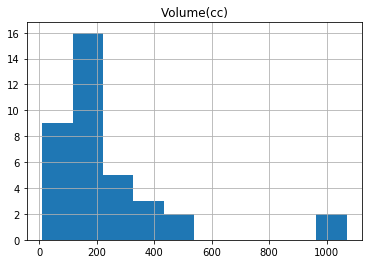

In [13]:
ptv_df.hist(column='Volume(cc)');

In [14]:
ptv_df.mean()

index         187.108108
Volume(cc)    239.577353
IsHighRes       0.000000
D95%(Gy)       51.154285
D25%(Gy)       54.176257
D50%(Gy)       53.250558
dtype: float64

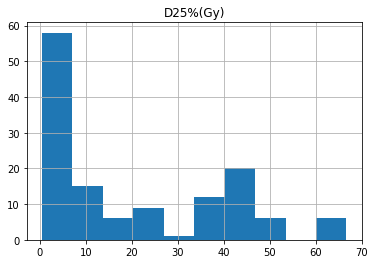

In [15]:
pd.read_sql_query(f'select * from {table_name} where DicomType=="ORGAN";', sql_connection).hist(column='D25%(Gy)');

## Saving DVH to HDF5 Using [H5Py](http://www.h5py.org)
*HDF5 lets you store huge amounts of numerical data, and easily manipulate that data from NumPy.*

Groups = Folders, Datasets = Files

* Create HDF5 file
* Create group for patient data in H5 file
* Get DVH data for a structure and save as dataset
* loop over patients DVH and save data to HDF5 file

In [16]:
import h5py
# we will reuse this code block to reset the file
try:
    h5file.close()
except NameError:
    pass
finally:
    h5file = h5py.File("DVH.h5",'w')  # truncate if exists

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [22]:
app.ClosePatient()
patient = app.OpenPatientById('RapidPlan-01')
patient_group = h5file.create_group(f'patients/{patient.Id}')

In [23]:
for label in h5file:
    print(label)

patients


In [24]:
# works like dictionary
for label in h5file['patients']:
    print(label)

RapidPlan-01


In [25]:
def ls(location,depth=0):
    for key,value in location.items():
        print(' ' * depth + ('\u21b3 ' if depth else '') + key)  # unicode for '↳'
        ls(value,depth+1)

In [26]:
ls(h5file)

patients
 ↳ RapidPlan-01


In [27]:
dvh_group = patient_group.create_group('structures/{}')

In [28]:
ls(h5file)

patients
 ↳ RapidPlan-01
  ↳ structures
   ↳ {}


In [ ]:
dvh = plan.GetDVHCumulativeData(
    structure,
    pyesapi.DoseValuePresentation.Relative,
    pyesapi.VolumePresentation.Relative,
    .01
)
dose_x = [p.DoseValue.Dose for p in dvh.CurveData]
volume_y = [p.Volume for p in dvh.CurveData]